# LELA70502 Directed Reading - Natural Generation with Language Models

Generation with language models is also sometimes called auto-regressive generation. It works by selecting and then outputting words from the vocabulary based on their probability given a preceding context - either (at time point 1) a prompt from the user, or (at subsequent time points) the prompt plus the words that have been generated so far.

There are however a wide range of ways in which they are chosen. This is what we are going to look at today - different methods of what is know as "decoding".

While real-world language models generate words based on neural language models (e.g. transformers) we can separate the underlying model from the decoding process and to keep things transparent we are going to start by applying generation methods using a simple n-gram language model.  


###Create bigram probability table

In [ ]:
import re
from collections import defaultdict
import numpy as np
import pandas as pd
# download from from the internet
!wget https://www.gutenberg.org/files/2554/2554-0.txt
# read in the file
f = open('2554-0.txt')
c_and_p = f.read()
# Remove the title page etc
# convert text to lower case
c_and_p=c_and_p[5464:]
c_and_p=c_and_p.lower()
c_and_p=re.sub('\n',' ', c_and_p)
# Add end of sentence token
c_and_p=re.sub("\. "," eol ", c_and_p)
c_and_p=re.sub('[^a-z ]','', c_and_p)
c_and_p=re.sub(' +', ' ',c_and_p)
c_and_p=re.split(" ", c_and_p)


from collections import defaultdict
total_unigrams = len(c_and_p) - 1
bigrams = defaultdict(int)
unigrams = defaultdict(int)
for i in range(total_unigrams-2):
    unigrams[c_and_p[i]] += 1
    bigrams[str.join(" ",c_and_p[i:i+2])] += 1

nested_dict = lambda: defaultdict(nested_dict)
d = nested_dict()

for bg in bigrams:
  ug = bg.split()
  #print(ug)
  d[ug[1]][ug[0]] = np.log(bigrams[bg]/unigrams[ug[0]])

lm=pd.DataFrame(d)

In [ ]:
lm

### Greedy Search

In [ ]:
# Define starting word
w="i"
# Define stopping point - here when an end of line character is output
while w != "eol":
  print(w,end=' ')
  # get probabilities for all words following the previous word
  s=lm.loc[w]
  # sort the probabilities and output the most likely word
  w=s.sort_values(ascending=False).index[0]


### Beam Search

In [ ]:
# Specify starting word
w="she"

# Set parameters
beam_size=5
max_length = 10

# initialise variable and data structures
length=0
candidates = {}
candidates[w] = 1
old_candidates=pd.Series(candidates)

# Define stopping point - here when an end of line character has appeared in all top ranked sentences or a maximum length has been reached
while sum([int("eol" in i.split()) for i in old_candidates.index]) < beam_size and length < max_length:
  length+=1
  candidates={}

  # Iterate over list of existing candidates
  for ind,(candidate, prob) in enumerate(old_candidates.items()):
      # For current candidate find last word and obtain sorted probability distribution over vocab for the next word
      cs= candidate.split()
      s=lm.loc[cs[-1]]
      candidate_words=s.sort_values(ascending=False).index

      # Add each candidate word to the end of the current candidate, update the probability of sequence so far to include new word and store in new candidate list
      for candidate_word in candidate_words:
         c=candidate+" "+candidate_word
         candidates[c]=prob+lm.loc[cs[-1],candidate_word]
  old_candidates=pd.Series(candidates)
  # Select top N candidates in line with beam size
  old_candidates=old_candidates.sort_values(ascending=False)[0:beam_size]
pd.Series(old_candidates).sort_values(ascending=False).index[0]

### Sampling

In [ ]:
import numpy as np
# Specify starting word
w="he"
# Define stopping point - here when an end of line character is output
while w != "eol":
  print(w,end=' ')
  # get probabilities for all words following the previous word
  s=lm.loc[w]
  s=s.drop(s[np.isnan(s)].index)
  # Choose randomly from the probability distribution over next words
  w=np.random.choice(list(s.index),1,list(np.exp(s.values)))[0]

### Top-k sampling

In [ ]:
import numpy as np
k=10
w="he"
while w != "eol":
  print(w,end=' ')
  s=lm.loc[w]
  s=s.drop(s[np.isnan(s)].index)
  s=s.sort_values(ascending=False)[0:k]
  newvals=np.exp(s.values)/sum(np.exp(s.values))
  w=np.random.choice(list(s.index),1,list(newvals))[0]

### Top-p sampling

In [ ]:
import numpy as np
w="he"

cutoff=0.75

def get_p(dist,threshhold):
  dist=dist.sort_values(ascending=False)
  dist=np.exp(dist)
  p=0
  cumul=0
  while cumul <= threshhold:
      cumul = cumul + dist.iloc[p]
      p+=1
  return p

while w != "eol":
  print(w,end=' ')
  s=lm.loc[w]
  s=s.drop(s[np.isnan(s)].index)
  p=get_p(s,cutoff)
  s=s.sort_values(ascending=False)[0:p]
  newvals=np.exp(s.values)/sum(np.exp(s.values))
  w=np.random.choice(list(s.index),1,list(newvals))[0]


### Demo of temperature in a softmax

Lower the temperature parameter towards 0. The lower the temperature, the greater the bias/lower the entropy.

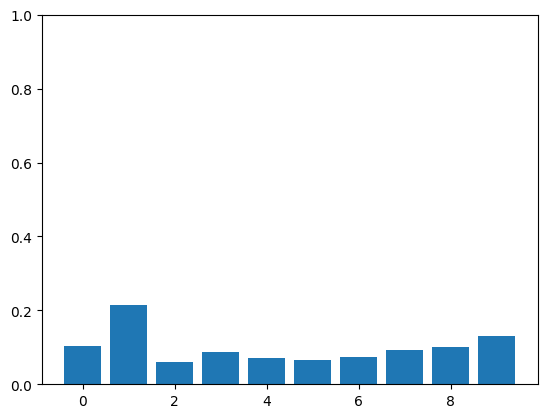

In [19]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

s = np.random.exponential(scale=1, size=10)

temperature=1

s2=np.exp(s/temperature)/np.sum(np.exp(s/temperature))

fig, ax = plt.subplots()
ax.set_ylim([0,1])
ax.bar(range(10), s2)

plt.show()
